# TP1 - Classification par Kppv

Dans ce TP, nous allons utiliser une partie de la base de visages ‚ÄúLabeled Faces in the Wild‚Äù provenant de http://vis-www.cs.umass.edu/lfw/. Cette base contient 5749 personnes et 13233 images de taille 62 x 47 pixels. Certaines personnes ne sont repr√©sent√©es qu‚Äôune seule fois tandis que d‚Äôautres sont repr√©sent√©es tr√®s souvent (plus de 80 fois). Nous utiliserons ici seulement 7 personnes repr√©sent√©es 1288 fois.

In [2]:
# Importer les librairies
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import DistanceMetric
from sklearn.decomposition import PCA
from time import perf_counter 

## I- Chargement des donn√©es:

### Charger les donn√©es
Charger les donner, puis afficher les en utilisant la fonction plot_gallery()  fournie.

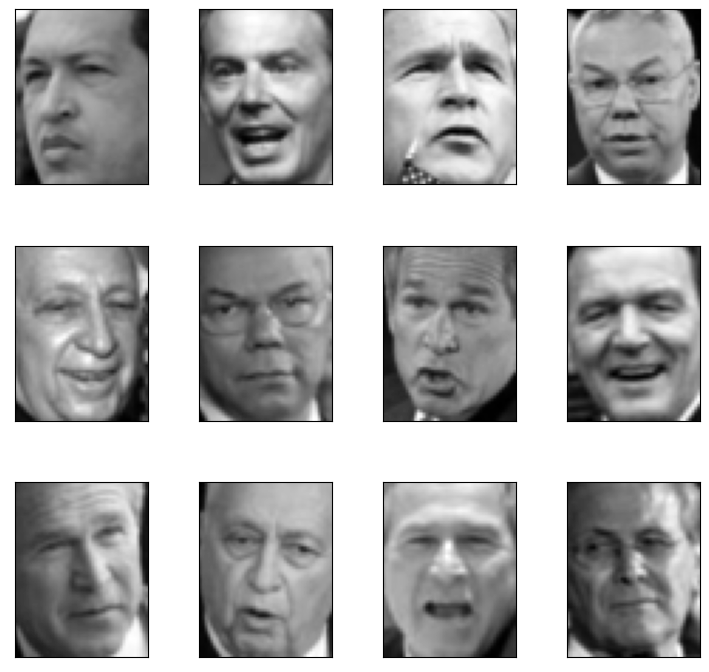

In [3]:
def plot_gallery(images):
# Affiche les 12 premi√®res images contenues dans images
# images est de taille Nb imageNyNx
    plt.figure(figsize=(7.2, 7.2))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())
    plt.show()
#Charger et afficher les donn√©es :
[X, y, name]=np.load("TP1.npy",allow_pickle=True )
plot_gallery(X)

#### Question

- Sachant que X repr√©sente les features, y les labels et name le nom des classes, d√©terminer la taille des images, le nombre d‚Äôimages et le nombre de classes.

- Retrouver l‚Äôidentit√© des 12 personnes affich√©es. Est-ce que les classes sont √©quiprobables ? 

- Retrouver le nombre d‚Äôexemples par classe. On pourra pour cela utiliser l‚Äôhistogramme (plt.hist()).

In [12]:
print(X.shape, y.shape, name.shape)
print(y, np.unique(y))


(1288, 62, 47) (1288,) (7,)
[5 6 3 ... 5 3 5] [0 1 2 3 4 5 6]


Il y a 1288 images de taille 62 x 47.
Ces 1288 images ont chacune un label de 0 √† 6.

In [16]:
print("The gallery shows the pictures of (in reading order) :")
print(name[y[0:11]])

The gallery shows the pictures of (in reading order) :
['Hugo Chavez' 'Tony Blair' 'George W Bush' 'Colin Powell' 'Ariel Sharon'
 'Colin Powell' 'George W Bush' 'Gerhard Schroeder' 'George W Bush'
 'Ariel Sharon' 'George W Bush']


In [20]:
print("Nombre d'√©l√©ments par classe :")
for i in range(7) : 
    print( (y == i).sum() )
print("Ces classes ne sont donc pas √©quiprobables")

Nombre d'√©l√©ments par classe :
77
236
121
530
109
71
144
Ces classes ne sont donc pas √©quiprobables


### Partitionnement de la base d‚Äôapprentissage

Partitionner la base en une base d‚Äôapprentissage et une base de test en mettant 25% des donn√©es
en test (fonction train_test_split()) pour obtenir les variables X_train, X_test, y_train et y_test.

#### Question
- Combien y a-t-il d‚Äôimages en train et en test ? 
- Quelles sont les dimensions des quatre variables X_train, X_test, y_train et y_test ?

In [24]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(966, 62, 47) (322, 62, 47) (966,) (322,)


Il y a 966 images en train et 322 en test.

Leurs dimensions sont donn√©es par les shape ci-dessus

## II. Pr√©traitement des donn√©es:

### Redimensionnement des donn√©es

Pour r√©aliser une classification par kppv, on utilise un codage r√©tinien. Chaque image est donc repr√©sent√©e par un vecteur de caract√©ristique de dimension ùëõ = 2914. Redimensionner X_train et X_test de fa√ßon √† ce qu‚Äôils aient pour dimension ùëÅ x ùëõ (np.reshape()) o√π N est le nombre d‚Äôexemples.

In [26]:
x_train=np.reshape(x_train, (x_train.shape[0], x_train.shape[1]*x_train.shape[2]) )
x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1]*x_test.shape[2]) )

### Mise en forme des donn√©es pour la classification

Mettre en forme les donn√©es (train et test) en utilisant la classe StandardScaler. On estimera la moyenne et l‚Äô√©cart-type de chaque dimension sur les donn√©es d‚Äôapprentissage, puis on transformera les donn√©es (train et test) en utilisant ces valeurs. Aller sur la documentation en
ligne de StandardScaler pour voir quelle m√©thode de cette classe utiliser.

In [43]:
ss_tr=StandardScaler()
x_train_ss=ss_tr.fit_transform(x_train)

ss_te=StandardScaler()
x_test_ss=ss_te.fit_transform(x_test)


#### Question
- A quoi consiste la mise en forme des donn√©es ? 

- Comment sont-elles transform√©es ?

La mise en forme des donn√©es consiste √† leur donn√©e une moyenne nulle et un √©cart-type de 1 en soustrayant la moyenne et en divisant la r√©sultante par l'√©cart-type.

In [44]:
print(f"Mean before scaling : {np.mean(x_train)},   Mean after : {np.mean(x_train_ss)}")
print(f"Stddev before scaling : {np.std(x_train)}, Stddev after : {np.std(x_train_ss)}")

Mean before scaling : 131.92611694335938,   Mean after : 9.540388479223338e-10
Stddev before scaling : 44.381492614746094, Stddev after : 0.9999998807907104


## III. Classification par les KPPV:

### Classifieur 1PPV

- D√©finir le classifieur 1PPV en utilisant la classe KNeighborsClassifier(). On souhaite utiliser la distance euclidienne et le 1PPV. 

- Train le classifieur sur X_train, y_train.

- R√©aliser la classification des exemples de test en utilisant la m√©thode predict().

In [99]:
cl_1ppv=KNeighborsClassifier(n_neighbors=1, weights='distance', metric='euclidean')
cl_1ppv.fit(x_train_ss, y_train)
y_pred=cl_1ppv.predict(x_test_ss)

# cl_1ppv.fit(x_train, y_train)
# y_pred=cl_1ppv.predict(x_test)


#### Questions 
- Que repr√©sente la matrice de confusion ?
- Que vaut sa somme ? 
- Est-ce que les classes sont √©quilibr√©es ?

La matrice de confusion indique la quantit√© de classification pr√©dite en chaque classe en fonction de chaque classe r√©elle.

La somme sur chaque ligne est le nombre d'√©l√©ment par classe, donc la somme sur les lignes et les colonnes donne le nombre d'√©l√©ments au total (dans l'ensemble de test).

In [100]:
co=confusion_matrix(y_test, y_pred)
print(f"Somme de la matrice de confusion : {co.sum()}")

print('\n')
for i in range(7) : 
    print( co[:,i].sum() )
print("Les classes apr√®s 1ppv ne sont donc toujours pas √©quilibr√©es")

Somme de la matrice de confusion : 322


16
54
36
147
25
10
34
Les classes apr√®s 1ppv ne sont donc toujours pas √©quilibr√©es


Afficher la matrice de confusion (fonction confusion_matrix()) et estimer le taux dereconnaissance √† partir des √©l√©ments de cette matrice. V√©rifier que le taux est identique √† celui renvoy√© par la fonction accuracy_score().

In [101]:
print(co)

print(f"Le taux de reconnaissance est de {np.diag(co).sum() / np.sum(co)}.")
print(f"L'accuracy score est de {accuracy_score(y_test, y_pred)}")

[[  6   3   0   8   0   0   1]
 [  1  33   5  10   3   0   3]
 [  1   4  19   4   3   0   4]
 [  4   9   8 108   5   0   5]
 [  0   2   2   3   9   2   6]
 [  0   1   0   5   0   8   2]
 [  4   2   2   9   5   0  13]]
Le taux de reconnaissance est de 0.6086956521739131.
L'accuracy score est de 0.6086956521739131


### Classifieur KPPV
Faire varier le K des KPPV et tracer l‚Äô√©volution du taux de reconnaissance en fonction de K.

In [106]:
acc_vec=np.zeros(20)
for i in range(1,21): 
    cl_ippv=KNeighborsClassifier(n_neighbors=i, weights='distance', metric='euclidean')
    cl_ippv.fit(x_train_ss, y_train)
    acc_vec[i-1]=accuracy_score(y_test, cl_ippv.predict(x_test_ss) )

#### Questions :

Conclusion ? Interpr√©ter l‚Äô√©volution des r√©sultats en fonction de K

Max pour K = 7


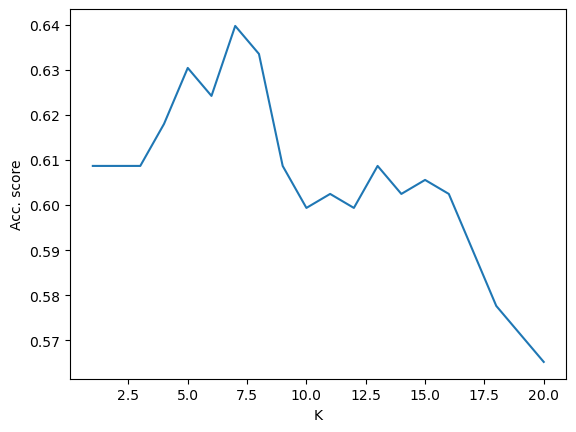

In [107]:
fig=plt.plot(range(1,21), acc_vec)
plt.xlabel('K')
plt.ylabel('Acc. score')
print(f"Max pour K = {np.argmax(acc_vec)+1}")

On voit que l'accuracy est ici maximale quand on regarde les 7 plus proches voisins, et que l'ajout de beaucoup de voisins n'am√©liore pas la classification.

### Classifieur KPPV et distance de Manhattan

R√©aliser les m√™mes tests avec la distance de Manhattan.

Max pour K = 3


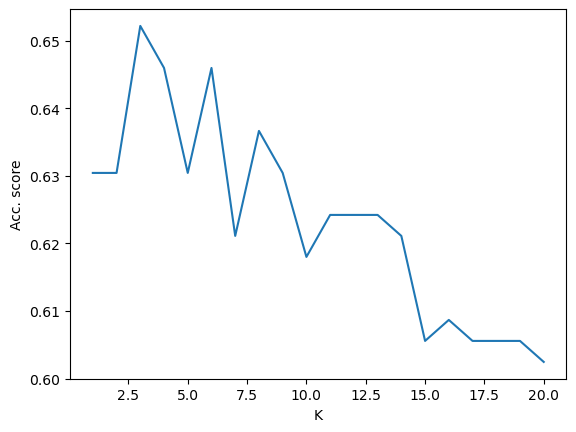

In [108]:
cl_1ppv=KNeighborsClassifier(n_neighbors=1, weights='distance', metric='manhattan')
cl_1ppv.fit(x_train_ss, y_train)
y_pred=cl_1ppv.predict(x_test_ss)

acc_vec=np.zeros(20)
for i in range(1,21): 
    cl_ippv=KNeighborsClassifier(n_neighbors=i, weights='distance', metric='manhattan')
    cl_ippv.fit(x_train_ss, y_train)
    acc_vec[i-1]=accuracy_score(y_test, cl_ippv.predict(x_test_ss) )
    
fig=plt.plot(range(1,21), acc_vec)
plt.xlabel('K')
plt.ylabel('Acc. score')
print(f"Max pour K = {np.argmax(acc_vec)+1}")

#### Questions :
- Conclusion ? Interpr√©ter l‚Äô√©volution des r√©sultats en fonction de K.
- Pour r√©soudre ce probl√®me de classification, quelle distance et valeur de K choisissez-vous suite √† ces tests ?

On a maintenant un maximum pour l'accuracy score qui est quasiment le m√™me avec 'manhattan' plut√¥t qu'avec 'euclidian', mais atteint pour 3 voisins plut√¥t que 7. 

Je choisirais donc une m√©thode utilisant la distance de manhattan avec les 3 plus proches voisins.

Cependant, je ne vois pas comment cette m√©thode est la meilleure. 

# TP2: Analyse en composantes principales, classification et reconstruction :



## I. Chargement et mise en forme des donn√©es:

On utilisera les m√™mes donn√©es que lors du TP1 avec leur redimensionnement et leur mise en forme.

#### Questions

- Combien y a-t-il de donn√©es en apprentissage et en test ?
- Quelle est la dimension des donn√©es apr√®s redimensionnement ?


In [110]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(966, 2914) (322, 2914) (966,) (322,)


## II. Analyse en composantes principales et classification

1. D√©finissez la d√©composition en composantes principales en utilisant la fonction PCA() en gardant le maximum de composantes, ajuster le mod√®le sur X_train (   ) puis tracer les variances en utilisant l‚Äôattribut pca.explained_variance_ratio_  


In [150]:
pca=PCA(n_components=966)
pca.fit(x_train, y_train)

PCA(n_components=966)

Text(0, 0.5, 'Variance')

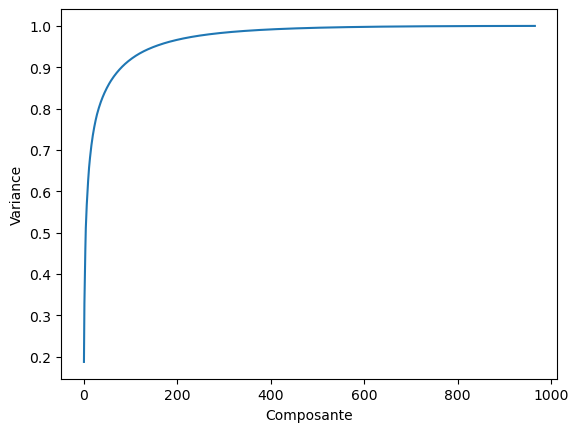

In [151]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Composante')
plt.ylabel('Variance')

2. Red√©finissez la d√©composition en utilisant la fonction   en conservant 100 composantes, ajuster le mod√®le sur X_train, puis transformez les donn√©es X_train et X_test pour obtenir X_train1 et X_test1.

In [152]:
pca=PCA(n_components=100)
pca.fit(x_train, y_train)
x_train1=pca.fit_transform(x_train)
x_test1=pca.transform(x_test)

In [153]:
x_test.shape, x_test1.shape, x_train.shape, x_train1.shape

((322, 2914), (322, 100), (966, 2914), (966, 100))

Text(0, 0.5, 'Variance')

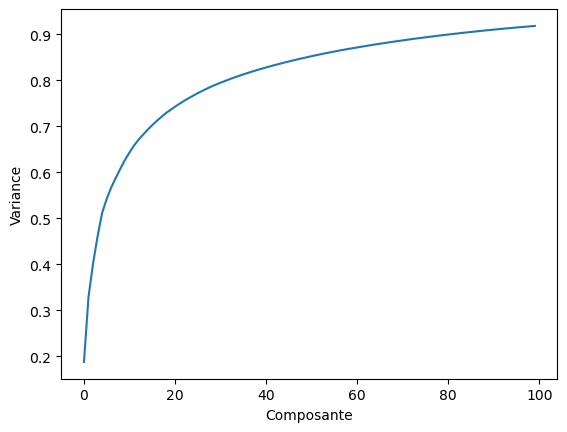

In [154]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Composante')
plt.ylabel('Variance')

3. R√©aliser la classification sur les donn√©es de d√©part puis sur les nouvelles donn√©es avec la m√©thode du 5PPV et la distance de Manhattan. Conclure sur le taux de reconnaissance et les temps de calcul qui peuvente √™tre d√©termin√©s par :



```
from time import perf_counter
 tps1 = perf_counter()
 tps2 = perf_counter()
 print("Dur√©e de classification",tps2 - tps1)
```



In [142]:
#classification sur les donn√©es de base : 
from time import perf_counter

tps1_base = perf_counter()

#On applique standard scale aux donn√©es non r√©duites (bien que d√©j√† fait, pour inclure
# dans le calcul de temps):
ss=StandardScaler()
x_train_ss=ss.fit_transform(x_train)
ss=StandardScaler()
x_test_ss=ss.fit_transform(x_test)

#on fait la classification 5ppv sur les donn√©es de base, puis les r√©duites
cl_5ppv=KNeighborsClassifier(n_neighbors=5, weights='distance', metric='manhattan')
cl_5ppv.fit(x_train_ss, y_train)
y_pred_base=cl_5ppv.predict(x_test_ss)

tps2_base=perf_counter()

print(f"Temps total : {tps2_base-tps1_base}")
print(f"Accuracy score : {accuracy_score(y_test, y_pred_base)}" )

Temps total 0.5388504820002709
Accuracy score : 0.6304347826086957


In [155]:
#classification sur les donn√©es r√©duites : 
tps1_red = perf_counter()

#On inclue la r√©duction de dimensions dans le temps
pca=PCA(n_components=100)
pca.fit(x_train, y_train)
x_train1=pca.fit_transform(x_train)
x_test1=pca.transform(x_test)

tps_int_red = perf_counter()

#On applique standard scale √† ces donn√©es r√©duites :
ss=StandardScaler()
x_train1_ss=ss.fit_transform(x_train1)
ss=StandardScaler()
x_test1_ss=ss.fit_transform(x_test1)


#on fait la classification 5ppv sur les donn√©es de base, puis les r√©duites
cl_5ppv_red=KNeighborsClassifier(n_neighbors=5, weights='distance', metric='manhattan')
cl_5ppv_red.fit(x_train1_ss, y_train)
y_pred_red=cl_5ppv_red.predict(x_test1_ss)

tps2_red=perf_counter()

print(f"Temps total {tps2_red-tps1_red}, Temps sans inclure la r√©duction de dimensions {tps2_red-tps_int_red}")
print(f"Accuracy score : {accuracy_score(y_test, y_pred_red)}" )


Temps total 0.10056694300146773, Temps sans inclure la r√©duction de dimensions 0.019281921999208862
Accuracy score : 0.6987577639751553


In [163]:
#Classification reports : 
from sklearn.metrics import classification_report
print("Rapport pour la version de base :")
print(classification_report(y_test, y_pred_base))
print('\n')
print("Rapport pour la version √† 100 composantes :")
print(classification_report(y_test, y_pred_red))
print('\n')
print(name)
#La r√©duction de dimension uniformise les precisions, mais pas les recall

Rapport pour la version de base :
              precision    recall  f1-score   support

           0       0.55      0.33      0.41        18
           1       0.61      0.60      0.61        55
           2       0.82      0.51      0.63        35
           3       0.67      0.89      0.76       139
           4       0.20      0.12      0.15        24
           5       1.00      0.38      0.55        16
           6       0.46      0.37      0.41        35

    accuracy                           0.63       322
   macro avg       0.62      0.46      0.50       322
weighted avg       0.63      0.63      0.61       322



Rapport pour la version √† 100 composantes :
              precision    recall  f1-score   support

           0       0.80      0.44      0.57        18
           1       0.77      0.78      0.77        55
           2       0.68      0.37      0.48        35
           3       0.69      0.92      0.79       139
           4       0.67      0.42      0.51        

#### Questions :

- Que repr√©sentent les valeurs renvoy√©es par pca.explained_variance_ratio_ ? 

- Observer la taille de X_train1 et X_test1. Quelle est la nouvelle dimension des donn√©es ?
- Comment varient les temps de calcul entre une classification avec ou sans ACP ?
- Comment varient les taux de reconnaissance ?

pca.explained_variance_ratio_ est "Percentage of variance explained by each of the selected components" d'apr√®s la documentation. 

In [164]:
x_test.shape, x_test1.shape, x_train.shape, x_train1.shape

((322, 2914), (322, 100), (966, 2914), (966, 100))

Les nouvelles dimensions ont 100 features au lieu de 2914

Le temps de calculs est plus rapide apr√®s r√©duction (0.10 s. au lieu de 0.53 s.), et l'accuracy score √† peu pr√®s √©gale, et m√™me un peu plus √©lev√© (0.69 au lieu de 0.63)

## III. Analyse en composantes principales et reconstruction

Le but est de compresser les images afin qu‚Äôelle prenne moins de place en m√©moire. On va donc d√©finir sur X_train la fa√ßon de compresser. Puis on comprimera et d√©comprimera les images de X_test afin de voir les pertes induites par la compression.

- D√©finissez la d√©composition en composantes principales en utilisant la fonction PCA() en conservant 50 composantes et ajuster le mod√®le sur X_train.


- R√©cup√©rer les vecteurs propres en utilisant un attribut de PCA(). 

- Redimensionner les vecteurs propres en images propres (np.reshape()) de mani√®re √† pourvoir les visualiser sous forme d‚Äôimages (array de taille 50x62x47). On utilisera la fonction plot_gallery() pour la visualisation.

In [10]:
#On recharge les donn√©es pour lancer uniquement les premi√®res cellules et celle-ci.

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
x_train=np.reshape(x_train, (x_train.shape[0], x_train.shape[1]*x_train.shape[2]) )
x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1]*x_test.shape[2]) )
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)


(966, 2914) (322, 2914) (966,) (322,)


In [12]:
#Entrainement du mod√®le
pca=PCA(n_components=50)
pca.fit(x_train, y_train)

#Vecteurs propres :
eigenvec=pca.components_
print(eigenvec)
print('\n')
print(eigenvec.shape)

#Images propres : 
eigenim=np.reshape(eigenvec, (50, 62, 47))

[[-0.00539484 -0.00570086 -0.00638358 ... -0.01069739 -0.00997495
  -0.00931057]
 [ 0.01859924  0.01748544  0.01701865 ... -0.03442015 -0.03455214
  -0.03352232]
 [ 0.01788918  0.01647882  0.01580279 ...  0.04275364  0.03867258
   0.03738027]
 ...
 [ 0.01887458  0.02017824  0.02662604 ...  0.00341664  0.01292538
   0.01975903]
 [-0.02124229 -0.02331815 -0.014675   ... -0.01185411 -0.03434577
  -0.04536716]
 [-0.01731597 -0.02192345 -0.01765944 ...  0.00639158  0.03874633
   0.05688018]]


(50, 2914)


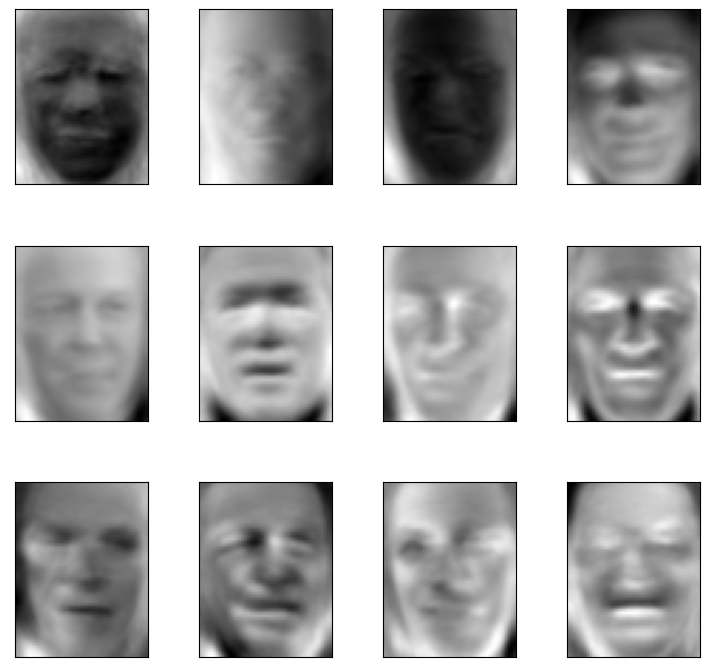

In [17]:
plot_gallery(eigenim) 

Questions:

- Que repr√©sentent les vecteurs propres ?
- Quelle est leur taille ?

Les vecteurs propres repr√©sentent: 

Les axes principaux dans l'espace d'entit√©s, repr√©sentant les directions de variance maximale dans les donn√©es. Les composants sont tri√©s par explication_variance_.

Ils sont de m√™me taille que les images de base.

- On souhaite comprimer les images de X_test afin de les transmettre en utilisant le moins de bande passante possible. Pour cela, les 50 images propres sont transmises une fois. Pour chaque nouvelle image, on transmet uniquement ses composantes dans le nouveau syst√®me d‚Äôaxe de dimension 50. L‚Äôimage est ensuite reconstruite √† l‚Äôarriv√©e.
Appliquer l‚ÄôACP des images de X_test (X_testC)

In [20]:
x_test_c=pca.transform(x_test)
x_test_c.shape

(322, 50)

- Reconstruisez les images √† partir X_testC pour obtenir les images X_testR √† partir d‚Äôune
des m√©thodes de PCA(). Afficher les images reconstruites et les comparer visuellement
aux images de d√©part.

(322, 2914) (322, 2914)


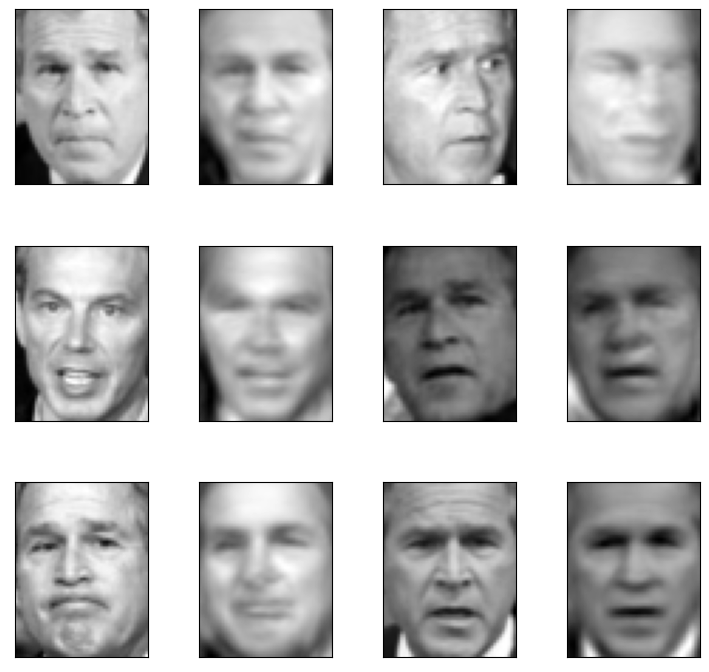

In [36]:
x_test_r=pca.inverse_transform(x_test_c)
print(x_test_r.shape, x_test.shape)

im_test_r=np.reshape(x_test_r, (322, 62,47))
im_test=np.reshape(x_test, (322, 62,47))
im_combined=np.zeros((322*2, 62, 47))
for i in range(322) : 
    im_combined[2*i,:,:]=  im_test[i,:,:]
    im_combined[2*i+1,:,:]=im_test_r[i,:,:]

# plot_gallery(im_test_r)
plot_gallery(im_combined)


-  Comparer les images initiales et reconstruites de mani√®re quantitative en faisant la
moyenne des distances euclidiennes :


```
E= (X_testR-X_test)**2
E = np.mean(np.sqrt(np.sum(E,axis=0)))
```

In [54]:
E= (x_test_r-x_test)**2
E = np.mean(np.sqrt(np.sum(E,axis=0)))
print(E, np.mean(np.sum(x_test,axis=0)) )
print(f"L'erreur quadratique moyenne est de l'ordre de "+ \
      f"{E/np.mean(np.sum(x_test,axis=0))*100 :0.2f}% des images.")


278.66577 42280.582
L'erreur quadratique moyenne est de l'ordre de 0.66% des images.


Questions: 

- Comparer les tailles de X_test et X_testC et en d√©duire le taux de compression.
- Observer la taille de X_testR. Quel est le principe de la reconstruction des images ?

- Comment passe-t-on de X_testC √† X_testR ?

In [46]:
print(x_test.shape, x_test_c.shape, x_test_r.shape, 1-x_test_c.shape[1]/x_test.shape[1])

(322, 2914) (322, 50) (322, 2914) 0.9828414550446122


On a un taux de compression de 98% en prenant 50 composantes. 

- Faire varier le nombre de composantes conserv√©es de 10 √† 950 par pas de 50 et calculer l‚Äôerreur de reconstruction. Afficher l‚Äôerreur de reconstruction en fonction du nombre de composantes.

In [63]:
vec_err=[]
vec_comp=[]

for i in range(10,1000,50) :
    #Entrainement du mod√®le
    pca=PCA(n_components=i)
    pca.fit(x_train, y_train)
    #S√©lection des composantes majeures
    x_test_c=pca.transform(x_test)
    x_test_c.shape
    #Reconstruction
    x_test_r=pca.inverse_transform(x_test_c)
    E= (x_test_r-x_test)**2
    E = np.mean(np.sqrt(np.sum(E,axis=0)))
    vec_err.append(E)
    vec_comp.append(i)


Text(0, 0.5, 'Erreur quadratique moyenne')

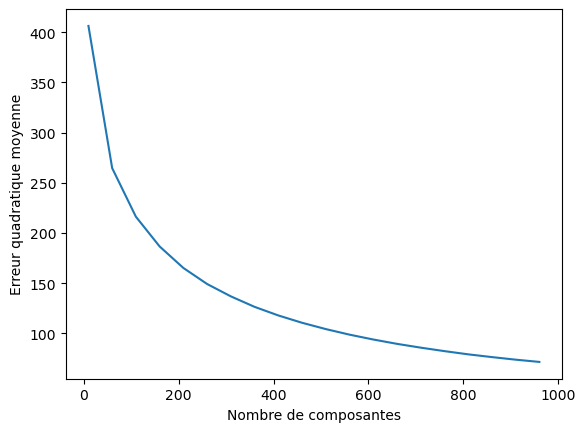

In [64]:
plt.plot(vec_comp, vec_err)
plt.xlabel('Nombre de composantes')
plt.ylabel('Erreur quadratique moyenne')

- Comment varie l‚Äôerreur de reconstruction en fonction du nombre de composantes ? 
- Comparer visuellement les images initiales et reconstruites √† partir de 950
composantes. Conclusion ?

L'erreur diminue grossi√®rement en 1 sur le nombre de composantes, donc on peut ignorer les derni√®res sans trop de pertes.

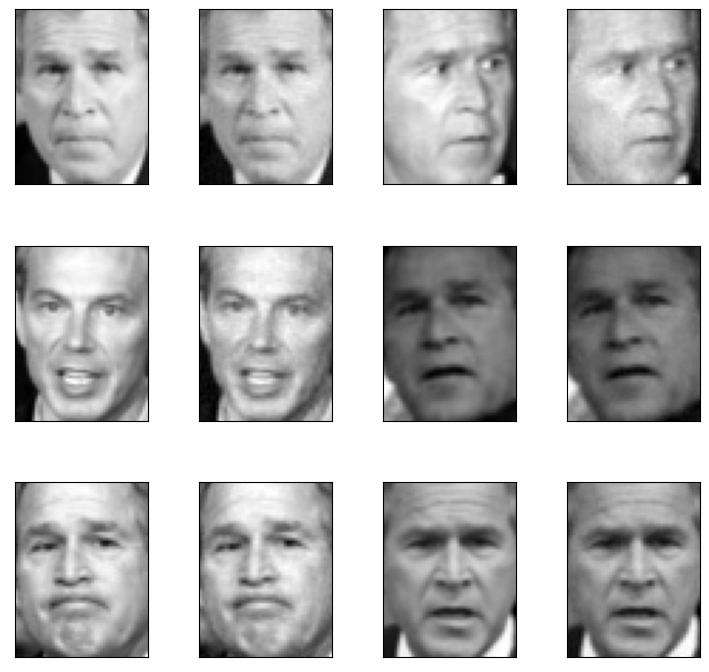

In [65]:
#Entrainement du mod√®le
pca=PCA(n_components=950)
pca.fit(x_train, y_train)
#S√©lection des composantes majeures
x_test_c=pca.transform(x_test)
x_test_c.shape
#Reconstruction
x_test_r=pca.inverse_transform(x_test_c)


im_test_r=np.reshape(x_test_r, (322, 62,47))
im_test=np.reshape(x_test, (322, 62,47))
im_combined=np.zeros((322*2, 62, 47))
for i in range(322) : 
    im_combined[2*i,:,:]=  im_test[i,:,:]
    im_combined[2*i+1,:,:]=im_test_r[i,:,:]

# plot_gallery(im_test_r)
plot_gallery(im_combined)

En supprimant les 15 derni√®res composantes, les pertes visuelles sont presque imperceptibles, mais on compresse seulement de 1.7%.

# Exemple perso : comparaison √† la fft


In [81]:
x_fft=np.fft.rfft2(np.reshape(x_test, (322, 62, 47)))
x_fft.shape

(322, 62, 24)

In [97]:
#approche de base
x_fft[:,20:, 10:]=0
x_fft_r=np.fft.irfft2(x_fft, s=(62, 47))

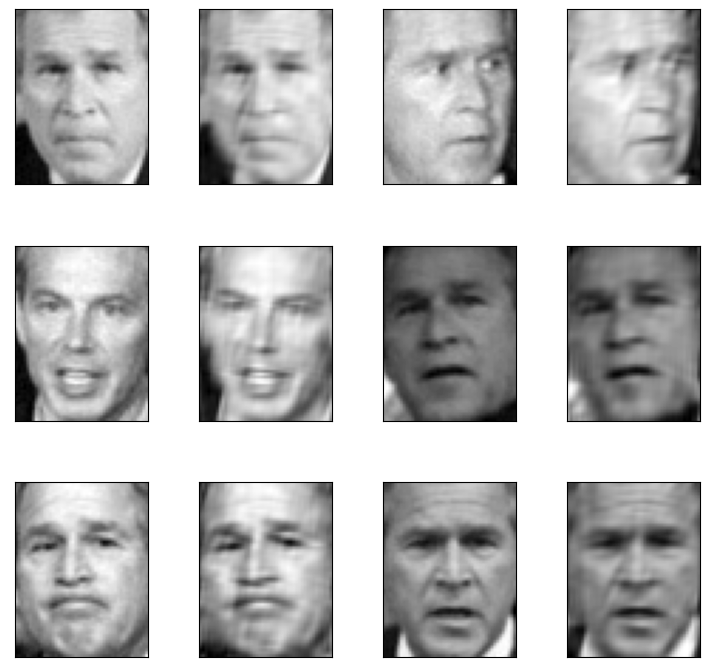

In [98]:
im_combined=np.zeros((322*2, 62, 47))
for i in range(322) : 
    im_combined[2*i,:,:]=  im_test_r[i,:,:]
    im_combined[2*i+1,:,:]=x_fft_r[i,:,:]

# plot_gallery(im_test_r)
plot_gallery(im_combined)


# plot_gallery(x_fft_r)

In [110]:
#calcul de l'erreur avec la compression : 
# On va caract√©riser le nombre de composantes comme le nombre de termes non nuls dans l'image par fft
#√† noter, la fft renvoie un complexe, donc deux fois plus de composantes

vec_err_fft=[]
vec_comp_fft=[] 

im_test=np.reshape(x_test, (322, 62, 47))

for i in range(1, 10) :
    ix=int(np.round(62/10*i))
    iy=int(np.round(47/10*i))
    x_fft=np.fft.rfft2(im_test)
    
    #S√©lection des composantes majeures
    x_fft[:,ix:,iy:]=0
    
    #Reconstruction
    x_fft_r=np.fft.irfft2(x_fft, s=(62, 47))
    E= (x_fft_r-im_test)**2
    E = np.mean(np.sqrt(np.sum(E)))
    vec_err_fft.append(E)
    vec_comp_fft.append(ix*iy/(62*47))


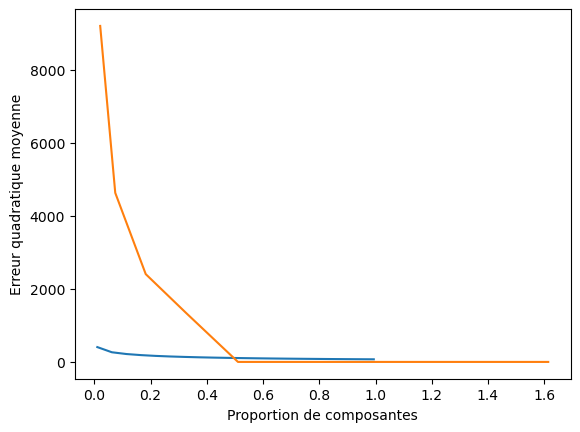

In [109]:
plt.plot(np.divide(vec_comp,966), vec_err)
plt.xlabel('Proportion de composantes')
plt.ylabel('Erreur quadratique moyenne')
plt.plot(np.multiply(vec_comp_fft,2), vec_err_fft)
plt.

In [ ]:
La fft d√©marre avec une plus grosse erreur, mais finit avec une plus basse erreur.